In [62]:
!pip install requests
!pip install beautifulsoup4
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install selenium
!pip install selenium-stealth
!pip install nest_asyncio

# **Imports**

In [63]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import csv
import asyncio
import aiohttp
import nest_asyncio
import random
from time import sleep
from selenium_stealth import stealth
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# **Web scraping**

In [70]:
# Applying nested event loops
nest_asyncio.apply()

# Fetcthing recipe page
async def fetch_recipe(session, recipe_link):
    async with session.get(recipe_link) as response:
        if response.status == 200:
            return await response.text()
        return None

# Fetching recipe links
async def fetch_recipes(session, page_number):
    url = f"https://www.skinnytaste.com/recipe-index/?_paged={page_number}"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    async with session.get(url, headers=headers) as response:
        if response.status == 200:
            soup = BeautifulSoup(await response.text(), 'html.parser')
            # Update the selector based on the actual HTML structure
            recipes = soup.find_all('h2', class_='entry-title')
            return [recipe.find('a')['href'] for recipe in recipes if recipe.find('a')]
        return []

# Main function for scraping
async def main():
    recipes_data = []
    async with aiohttp.ClientSession() as session:
        semaphore = asyncio.Semaphore(5)  # 5 concurrent requests

        async def fetch_with_semaphore(link):
            async with semaphore:
                recipe_page = await fetch_recipe(session, link)
                await asyncio.sleep(random.uniform(1, 3))  # Delay
                return recipe_page

        # Looping trough pages
        for i in range(1, 51):
            print(f"Fetching page {i}...")
            recipe_links = await fetch_recipes(session, i)
            print(f"Page {i}: Found {len(recipe_links)} recipes.")

            # Fetching each pages concurrently
            tasks = [fetch_with_semaphore(link) for link in recipe_links]
            recipe_pages = await asyncio.gather(*tasks)

            for recipe_page in recipe_pages:
                if recipe_page:
                    recipe_soup = BeautifulSoup(recipe_page, 'html.parser')

                    # Extracting data
                    recipe_name = recipe_soup.find('h1', class_='entry-title').text.strip() if recipe_soup.find('h1', class_='entry-title') else 'N/A'
                    summary_text = recipe_soup.find('div', class_='entry-content clear').find('p').text.strip() if recipe_soup.find('div', class_='entry-content clear').find('p') else 'N/A'
                    calories_text = recipe_soup.find('span', class_='recipe-meta-value value-calories').text.strip() if recipe_soup.find('span', class_='recipe-meta-value value-calories') else 'N/A'
                    personal_points_text = recipe_soup.find('span', class_='recipe-meta-value recipe-ww-pp icon').text.strip() if recipe_soup.find('span', class_='recipe-meta-value recipe-ww-pp icon') else 'N/A'
                    recipe_keys = recipe_soup.find('ul', class_='cat-icons post-icons')
                    if recipe_keys:
                      recipe_keys_text = ', '.join(key.text.strip() for key in recipe_keys.find_all('li'))
                    else:
                      recipe_keys_text = 'N/A'

                    image_links = recipe_soup.find_all('img', attrs={'fetchpriority': 'high'})
                    image_link = 'N/A'
                    for img in image_links:
                        link = img['src']
                        if "logo" not in link.lower():
                            image_link = link
                            break

                    # Appending to list
                    recipes_data.append({
                        'name': recipe_name,
                        'summary': summary_text,
                        'calories': calories_text,
                        'personal_points': personal_points_text,
                        'recipe_keys': recipe_keys_text,
                        'image_link': image_link
                    })

    # Converting to DataFrame
    df = pd.DataFrame(recipes_data)

    # Removing rows where personal points are missing, aka not recipes
    df = df[df['personal_points'] != 'N/A']

    # Removing "Cals:" text from the calories column
    df['calories'] = df['calories'].str.replace("Cals:", "").str.strip()

    return df

if __name__ == "__main__":
    df = asyncio.run(main())  # DataFrame to async function
    if df.empty:
        print("No data scraped. Please check the scraping logic.")
    else:
        print("Data scraping complete.")
        print(df)

        # Saving to csv
        df.to_csv('recipes.csv', index=False)

Fetching page 1...
Page 1: Found 20 recipes.
Fetching page 2...
Page 2: Found 20 recipes.
Fetching page 3...
Page 3: Found 20 recipes.
Fetching page 4...
Page 4: Found 20 recipes.
Fetching page 5...
Page 5: Found 20 recipes.
Fetching page 6...
Page 6: Found 20 recipes.
Fetching page 7...
Page 7: Found 20 recipes.
Fetching page 8...
Page 8: Found 20 recipes.
Fetching page 9...
Page 9: Found 20 recipes.
Fetching page 10...
Page 10: Found 20 recipes.
Fetching page 11...
Page 11: Found 20 recipes.
Fetching page 12...
Page 12: Found 20 recipes.
Fetching page 13...
Page 13: Found 20 recipes.
Fetching page 14...
Page 14: Found 20 recipes.
Fetching page 15...
Page 15: Found 20 recipes.
Fetching page 16...
Page 16: Found 20 recipes.
Fetching page 17...
Page 17: Found 20 recipes.
Fetching page 18...
Page 18: Found 20 recipes.
Fetching page 19...
Page 19: Found 20 recipes.
Fetching page 20...
Page 20: Found 20 recipes.
Fetching page 21...
Page 21: Found 20 recipes.
Fetching page 22...
Page 22: Fo

# **Visualization**

In [71]:
df = pd.read_csv('recipes.csv') #Loading DataFrame back outside of async function
print(df)

                                         name  \
0                          Breakfast Burritos   
1                       Crustless Pumpkin Pie   
2                            Red Curry Salmon   
3                                Apple Butter   
4                     Roasted Delicata Squash   
..                                        ...   
933                    Cream of Broccoli Soup   
934                  Cilantro-Lime Fish Tacos   
935  Kale and Potato Soup with Turkey Sausage   
936                      Banana Foster Crepes   
937            Instant Pot Chicken Taco Chili   

                                               summary  calories  \
0    These freezer breakfast burritos are stuffed w...     261.0   
1    Skip the crust and make this easy gluten-free,...     124.5   
2    Thai-inspired Red Curry Salmon is simmered in ...     349.0   
3    This easy apple butter recipe simmers on the s...      34.0   
4    Roasted Delicata Squash with toasted almonds, ...     177.0   
.. 

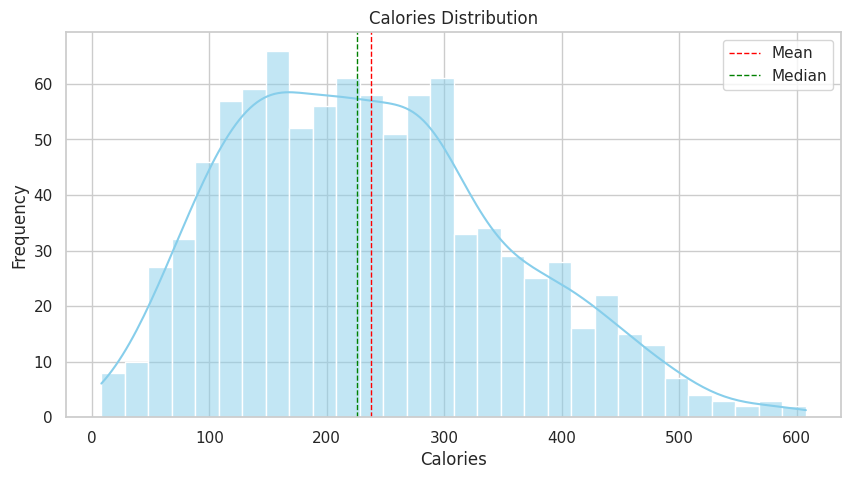

<ipython-input-72-cb9a6d31b835>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=recipe_keys_count.index[:10], y=recipe_keys_count.values[:10], palette='viridis')


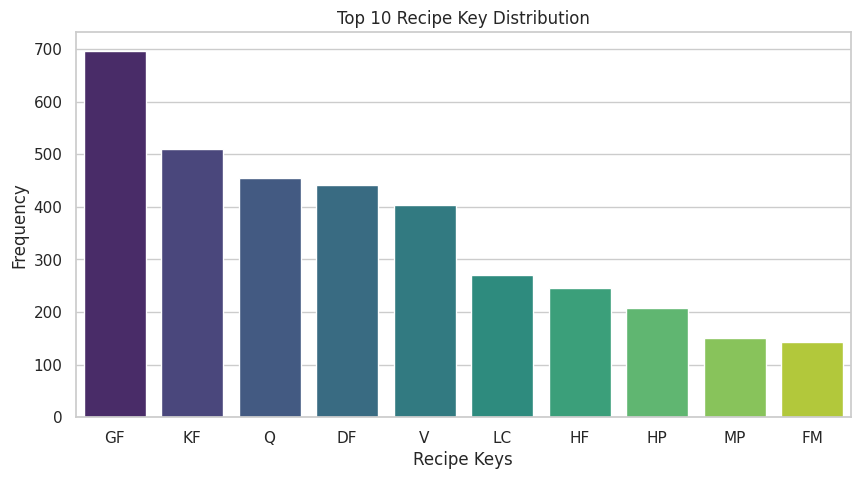

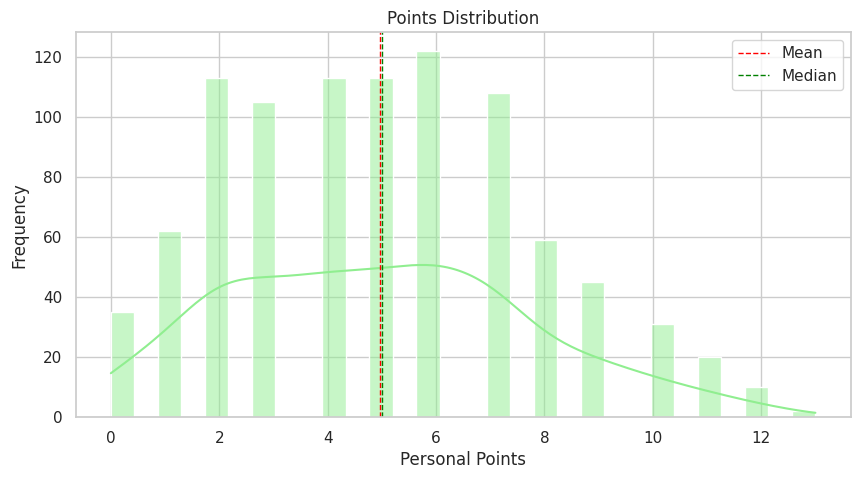

In [72]:
# Converting calories and personal points to numeric types
df['calories'] = pd.to_numeric(df['calories'], errors='coerce')
df['personal_points'] = pd.to_numeric(df['personal_points'], errors='coerce')


sns.set(style="whitegrid")

# Calories Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['calories'], bins=30, kde=True, color='skyblue')
plt.title('Calories Distribution')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.axvline(df['calories'].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(df['calories'].median(), color='green', linestyle='dashed', linewidth=1, label='Median')
plt.legend()
plt.show()

# Recipe Key Distribution

recipe_keys_exploded = df['recipe_keys'].str.split(',').explode().str.strip() # Exploding recipe keys into separate rows
recipe_keys_count = recipe_keys_exploded.value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=recipe_keys_count.index[:10], y=recipe_keys_count.values[:10], palette='viridis')
plt.title('Top 10 Recipe Key Distribution')
plt.xlabel('Recipe Keys')
plt.ylabel('Frequency')
plt.show()

# Points Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['personal_points'], bins=30, kde=True, color='lightgreen')
plt.title('Points Distribution')
plt.xlabel('Personal Points')
plt.ylabel('Frequency')
plt.axvline(df['personal_points'].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(df['personal_points'].median(), color='green', linestyle='dashed', linewidth=1, label='Median')
plt.legend()
plt.show()

# **User Interaction**

In [73]:
# Input for Calorie and Points Range
calorie_min = float(input("Enter minimum calorie value: "))
calorie_max = float(input("Enter maximum calorie value: "))
points_min = float(input("Enter minimum point value: "))
points_max = float(input("Enter maximum point value: "))

# Filteing DataFrame
filtered_df = df[(df['calories'] >= calorie_min) & (df['calories'] <= calorie_max) &
                  (df['personal_points'] >= points_min) & (df['personal_points'] <= points_max)]

# Sorting Order
sort_order = input("Do you want to sort the recipes by calories in ascending or descending order? (Enter 'asc' for ascending or 'desc' for descending): ").strip().lower()

# Sorting filtered DataFrame
if sort_order == 'asc':
    sorted_df = filtered_df.sort_values(by='calories').head(10)  # Get first 10 results in ascending order
elif sort_order == 'desc':
    sorted_df = filtered_df.sort_values(by='calories', ascending=False).head(10)  # Get first 10 results in descending order
else:
    print("Invalid input for sorting order. Defaulting to ascending order.")
    sorted_df = filtered_df.sort_values(by='calories').head(10)

# Results
if not sorted_df.empty:
    print("\nTop 10 Recipes based on your criteria:")
    for _, row in sorted_df.iterrows():
        print(f"\nRecipe Name: {row['name']}")
        print(f"Summary: {row['summary']}")
        print(f"Calories: {row['calories']}")
        print(f"Personal Points: {row['personal_points']}")
        print(f"Image Link: {row['image_link']}")
else:
    print("No recipes match your criteria.")

Enter minimum calorie value: 200
Enter maximum calorie value: 600
Enter minimum point value: 0
Enter maximum point value: 6
Do you want to sort the recipes by calories in ascending or descending order? (Enter 'asc' for ascending or 'desc' for descending): desc

Top 10 Recipes based on your criteria:

Recipe Name: 5-Minute Microwave Salmon Rice Bowl with Bok Choy
Summary: If you don’t have time to cook, you’ll love this 5-minute Salmon Rice Bowl with Bok Choy made in the microwave!
Calories: 533.0
Personal Points: 5
Image Link: https://www.skinnytaste.com/wp-content/uploads/2023/02/5-Minute-Glazed-Salmon-Rice-Bowl-13.jpg

Recipe Name: Nicoise Salad
Summary: I used salmon in place of tuna in this variation of the classic French Niçoise salad! This composed salad contains olives, artichokes, potatoes, green beans, and a whole-grain mustard vinaigrette.
Calories: 494.0
Personal Points: 5
Image Link: https://www.skinnytaste.com/wp-content/uploads/2024/05/Salmon-Nicoise-Salad-5.jpg

Recipe N